In [551]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

In [552]:
# from google.colab import drive
# drive.mount('/content/drive')

# Lectura de datos

In [553]:
# DIR = "/content/drive/MyDrive/Data Mining Properati/"
#df_train = pd.read_csv(DIR + "properati_entrenamiento.zip", index_col="id")  
#df_test = pd.read_csv(DIR + "properati_a_predecir.zip", index_col="id")  
df_test = pd.read_feather('bases/properati_a_predecir.ftr').set_index('id')
df_train = pd.read_feather('bases/properati_entrenamiento.ftr').set_index('id')

# df_test = pd.read_feather(DIR+'properati_a_predecir.ftr').set_index('id')
# df_train = pd.read_feather(DIR+'properati_entrenamiento.ftr').set_index('id')
# df_test.head()

# Entendimiento (magia parte 1 -- AID)

In [554]:
df_test.head()

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,l4,...,bathrooms,surface_total,surface_covered,price,currency,price_period,title,description,property_type,operation_type
id,,,,,,,,,,,,,,,,,,,,,
556713,Propiedad,2019-11-29,9999-12-31,2019-11-29,-58.442399,-34.573623,Argentina,Capital Federal,Colegiales,None,...,2.0,NaN,NaN,NaN,USD,None,"Departamento en Venta en Belgrano, Capital fed...","Sup total por escritura: 96,47 m2 (cubiertos: ...",Departamento,Venta
192912,Propiedad,2020-06-05,2020-06-08,2020-06-05,-58.430493,-34.606620,Argentina,Capital Federal,Almagro,None,...,2.0,77.0,67.0,NaN,USD,None,Departamento de 3 ambientes en Venta en Almagro,Excelente departamento de tres ambientes ampli...,Departamento,Venta
238224,Propiedad,2020-07-01,9999-12-31,2020-07-01,-58.491760,-34.574123,Argentina,Capital Federal,Villa Urquiza,None,...,1.0,60.0,55.0,NaN,USD,None,Andonaegui 2600 4° - - Departamento en Venta,Excelente 3 ambientes al frente con balcón. Vi...,Departamento,Venta
257134,Propiedad,2019-08-17,9999-12-31,2019-08-17,-58.420737,-34.631770,Argentina,Capital Federal,Boedo,None,...,1.0,74.0,47.0,NaN,USD,None,PH Venta Boedo 2 amb Patio,Corredor Responsable: MARCELO TRUJILLO - CPI ...,PH,Venta
521738,Propiedad,2019-08-05,2019-08-31,2019-08-05,-58.429983,-34.607225,Argentina,Capital Federal,Almagro,None,...,1.0,66.0,64.0,NaN,USD,None,Venta 3 Ambientes - Almagro - Balcón - Ameniti...,Corredor Responsable: Marcelo Trujillo - CUCIC...,Departamento,Venta


In [555]:
prueba = df_test.copy()

prueba.start_date = pd.to_datetime(prueba.start_date)

prueba.loc[prueba.end_date=='9999-12-31','end_date'] = np.nan

prueba.end_date = pd.to_datetime(prueba.end_date)
prueba.created_on = pd.to_datetime(prueba.created_on)

In [556]:
train = df_train.copy()

train.start_date = pd.to_datetime(train.start_date)

train.loc[train.end_date=='9999-12-31','end_date'] = np.nan

train.end_date = pd.to_datetime(train.end_date)
train.created_on = pd.to_datetime(train.created_on)

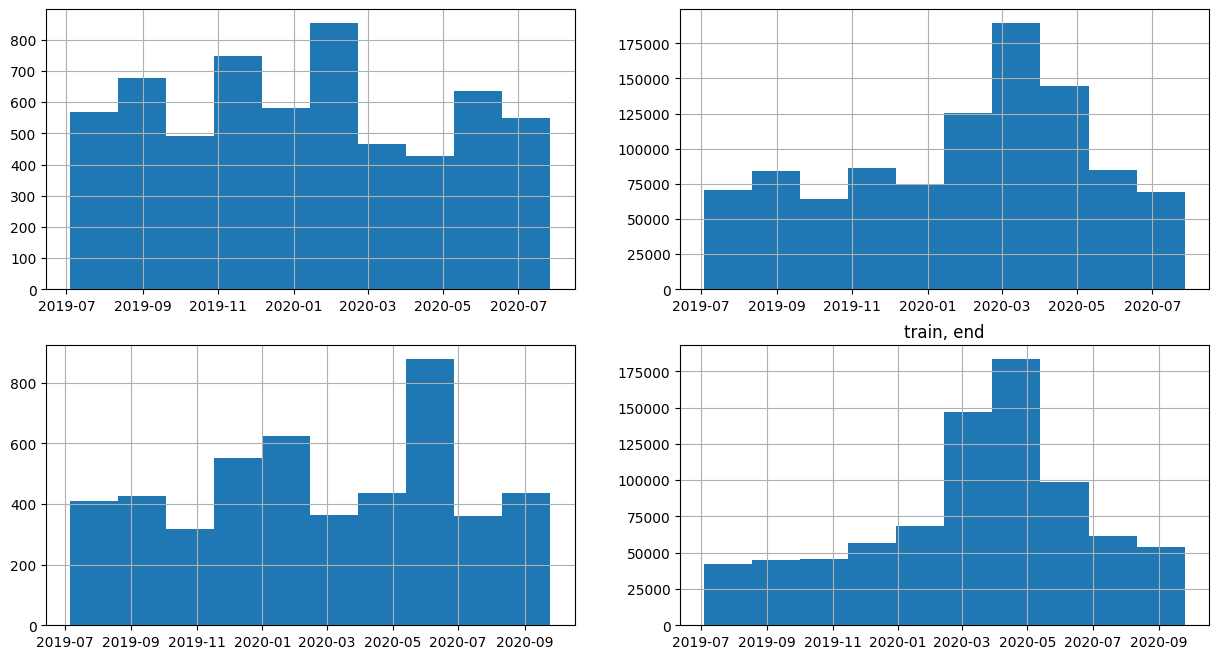

In [557]:
fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(15,8))
prueba.start_date.hist(ax=ax[0,0])
ax[0,0] = plt.title('test, start')
prueba.end_date.hist(ax=ax[1,0])
ax[1,0] = plt.title('test, end')
train.start_date.hist(ax=ax[0,1])
ax[0,1] = plt.title('train, start')
train.end_date.hist(ax=ax[1,1])
ax[1,1] = plt.title('train, end')


# Limpieza y transformación de datos (magia parte 2 -- MD)

In [558]:
raro = df_test['surface_total']<df_test['surface_covered']

df_test.loc[raro,'surface_total'], df_test.loc[raro,'surface_covered'] = df_test.loc[raro,'surface_covered'], df_test.loc[raro,'surface_total']

In [559]:
raro = df_train['surface_total']<df_train['surface_covered']

df_train.loc[raro,'surface_total'], df_train.loc[raro,'surface_covered'] = df_train.loc[raro,'surface_covered'], df_train.loc[raro,'surface_total']

In [560]:
en_amba_train = (df_train.lat>-60)&(df_train['lon']>-35.5)&(df_train['lon']<-34)& (df_train.lat<-56.5) & (df_train.l1=='Argentina')
en_amba_test  =  (df_test.lat>-60)&(df_test['lon']>-35.5)&(df_test['lon']<-34)& (df_test.lat<-56.5) & (df_test.l1=='Argentina')

# en_ballester = ((df_train.title.str.upper().str.contains('BALLESTER')) | (df_train.description.str.upper().str.contains('BALLESTER'))&
#                 en_amba_train)
# ballester = df_train[en_ballester]

no_lugares = ['Bs.As. G.B.A. Zona Sur','Bs.As. G.B.A. Zona Norte','Bs.As. G.B.A. Zona Oeste']

#Filtramos los que se encuentran dentro del rango de AMBA y que no son del conurbano
df_train = df_train[en_amba_train & (~df_train.l2.isin(no_lugares))]

#Pulimos la zona circundante a la plata para que coincida con el test
df_train = df_train[(df_train.l2=='Capital Federal')|((df_train.l2=='Buenos Aires Interior')&(df_train.lat>-58.15)&(df_train.lon<-34.7)&(df_train.lon>-35.1))]

# df_train = pd.concat((df_train,ballester),axis=0)

df_train = df_train[(df_train.price_period=='Mensual')|(df_train.price_period.isnull())] #TODO ver si sacarlo 

df_train.loc[df_train.l2=='Buenos Aires Interior','l2'] = 'Bs.As. G.B.A. Zona Sur'

df_train = df_train[df_train.operation_type=='Venta']

df_test.loc[df_test.title.str.contains('en Las Cañitas'),'l3'] = "Las Cañitas"
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas')) & (df_test.lat<-58.4),'lat'] = np.nan

df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.47),'l3'] = 'Villa Urquiza'
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')) & (df_train.lat<-58.44),['lat','lon']] = np.nan

df_train.shape

(152720, 24)

In [561]:
df_test.loc[~en_amba_test,['lat','lon']] = np.nan

In [562]:
cols_a_imputar = ['rooms','bedrooms','bathrooms','surface_total','surface_covered','lat','lon']
# crear nuevas columnas para indicar los valores imputados
for column in cols_a_imputar:
    is_imputed_train = np.where(df_train[column].isnull(), True, False)
    is_imputed_test = np.where(df_test[column].isnull(), True, False)
    df_train[column + '_imputed'] = is_imputed_train
    df_test[column + '_imputed'] = is_imputed_test

In [563]:
#df_train['train_test'] = 'train'
#df_test['train_test'] = 'test'

#df = pd.concat((df_train,df_test),axis=0)

#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(dos|2) baños'))   ,'bathrooms'] = 2
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(tres|3) baños'))  ,'bathrooms'] = 3
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cuatro|4) baños')),'bathrooms'] = 4
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(cinco|5) baños')) ,'bathrooms'] = 5
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('(seis|6) baños'))  ,'bathrooms'] = 6
#df.loc[(df.bathrooms.isna())&(df.description.str.contains('baño(\ |\.|\,)'))  ,'bathrooms'] = 1

#df_train = df[df.train_test=='train']
#df_test = df[df.train_test=='test']

#df_train.drop(columns='train_test',inplace=True)
#df_test.drop(columns='train_test',inplace=True)

In [564]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [565]:
imp = IterativeImputer(max_iter=10, random_state=42)  # tiene add_indicator

cols_a_imputar = ['rooms','bedrooms','bathrooms', 'surface_total','surface_covered']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

cols_a_imputar = ['lat','lon']
df_test[cols_a_imputar] = imp.fit_transform(df_test[cols_a_imputar])
df_train[cols_a_imputar] = imp.fit_transform(df_train[cols_a_imputar])

c:\Users\Usuario\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\impute\_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [566]:

df_test.rooms      = df_test.rooms.astype('int')
df_train.rooms     = df_train.rooms.astype('int')
df_test.bedrooms   = df_test.bedrooms.astype('int')
df_train.bedrooms  = df_train.bedrooms.astype('int')
df_test.bathrooms  = df_test.bathrooms.astype('int')
df_train.bathrooms = df_train.bathrooms.astype('int')

## Filtrado

In [567]:
pd.concat((df_train.property_type.value_counts(dropna=False),
           df_test.property_type.value_counts(dropna=False)),axis=1).sort_index()

,property_type,property_type
Casa,6878,NaN
Casa de campo,7,NaN
Cochera,2894,NaN
Departamento,97209,5426.0
Depósito,917,NaN
Local comercial,5940,NaN
Lote,8230,NaN
Oficina,4983,NaN
Otro,15649,NaN
PH,10013,574.0


In [568]:
df_train = df_train[df_train.property_type.isin(['PH','Departamento'])]

In [569]:
pd.concat((df_train.bathrooms.value_counts(dropna=False),
           df_test.bathrooms.value_counts(dropna=False)),axis=1)

,bathrooms,bathrooms
1,72464,4605.0
2,23804,1227.0
3,6969,144.0
4,2254,20.0
0,915,NaN
5,633,1.0
6,113,3.0
7,28,NaN
8,12,NaN
11,4,NaN


In [570]:
df_train = df_train[(df_train['bathrooms']<=6) | (df_train['bathrooms'].isnull())]
df_train.shape

(107152, 31)

In [571]:
pd.concat((df_train.currency.value_counts(dropna=False),
           df_test.currency.value_counts(dropna=False)),axis=1)

,currency,currency
USD,102422,6000.0
None,3910,NaN
ARS,820,NaN


In [572]:
df_train = df_train[df_train.currency=='USD'] #saco tambien los nulos porque no tienen precio
df_train.shape

(102422, 31)

In [573]:
pd.concat((df_train.rooms.value_counts(dropna=False),
           df_test.rooms.value_counts(dropna=False)),axis=1).sort_index()

,rooms,rooms
1,20682,NaN
2,30582,2984.0
3,26593,3016.0
4,17756,NaN
5,4668,NaN
6,1264,NaN
7,481,NaN
8,258,NaN
9,46,NaN
10,45,NaN


In [574]:
# df_train = df_train[(df_train.rooms<7) |(df_train.rooms.isnull())]
df_train.shape

(102422, 31)

In [575]:
pd.concat((df_train.bedrooms.value_counts(dropna=False),
           df_test.bedrooms.value_counts(dropna=False)),axis=1).sort_index()

,bedrooms,bedrooms
-1,2,NaN
0,15245,3.0
1,38133,3312.0
2,27821,2660.0
3,16558,23.0
4,3729,1.0
5,507,1.0
6,227,NaN
7,144,NaN
8,22,NaN


In [576]:
# df_train = df_train[(df_train.bedrooms<6) |(df_train.bedrooms.isnull())]
df_train.shape

(102422, 31)

<AxesSubplot: xlabel='surface_covered'>

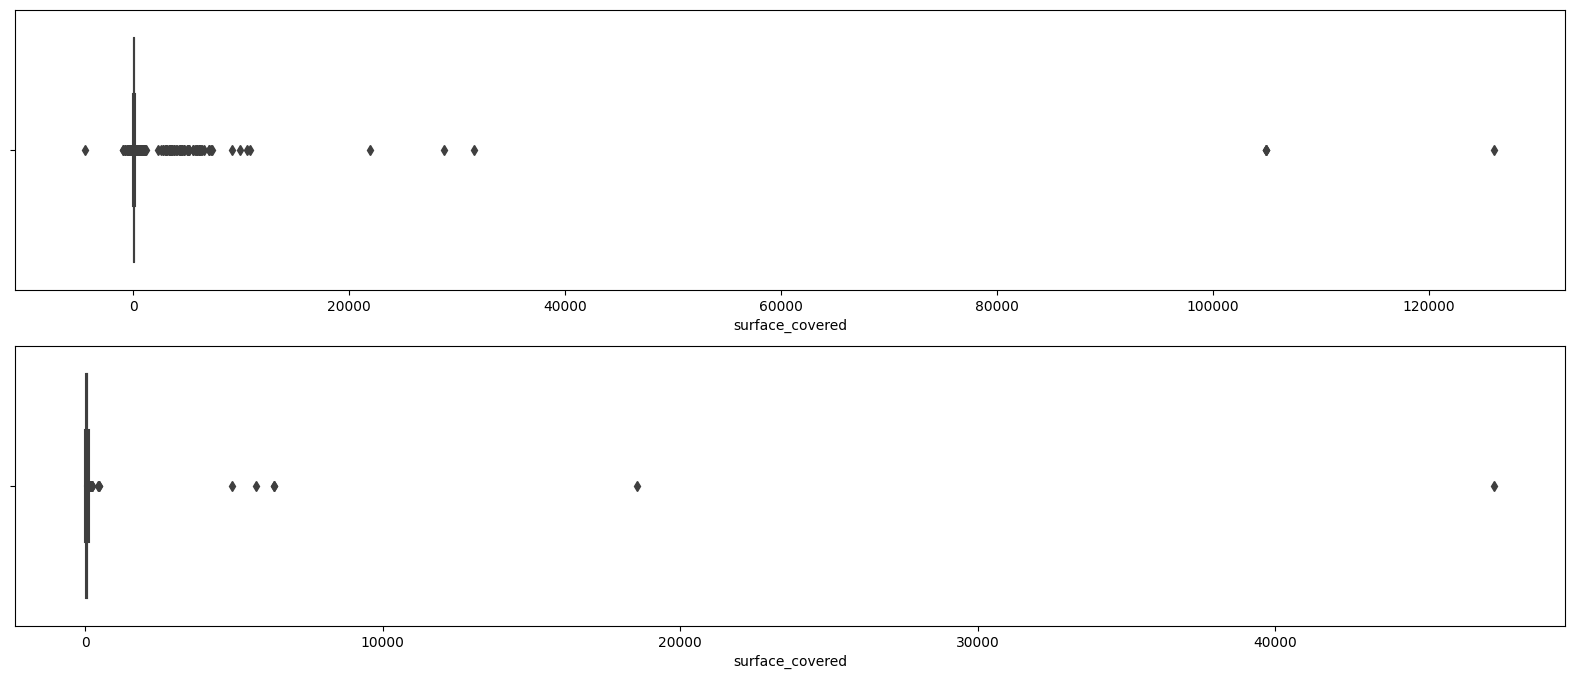

In [577]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_covered',ax=ax[0])
sns.boxplot(data=df_test,x='surface_covered',ax=ax[1])

In [578]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,102422.0,87.192914,720.887917,-4432.263411,41.0,61.0,98.0,126062.0
surface_total,102422.0,138.086412,1024.722444,-149575.086421,43.0,69.0,130.0,126062.0


In [579]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [580]:
df_train = df_train[((df_train['surface_covered']>=20)&(df_train['surface_covered']<50000))|(df_train['surface_covered'].isnull())]
df_train.shape

(100591, 31)

<AxesSubplot: xlabel='surface_total'>

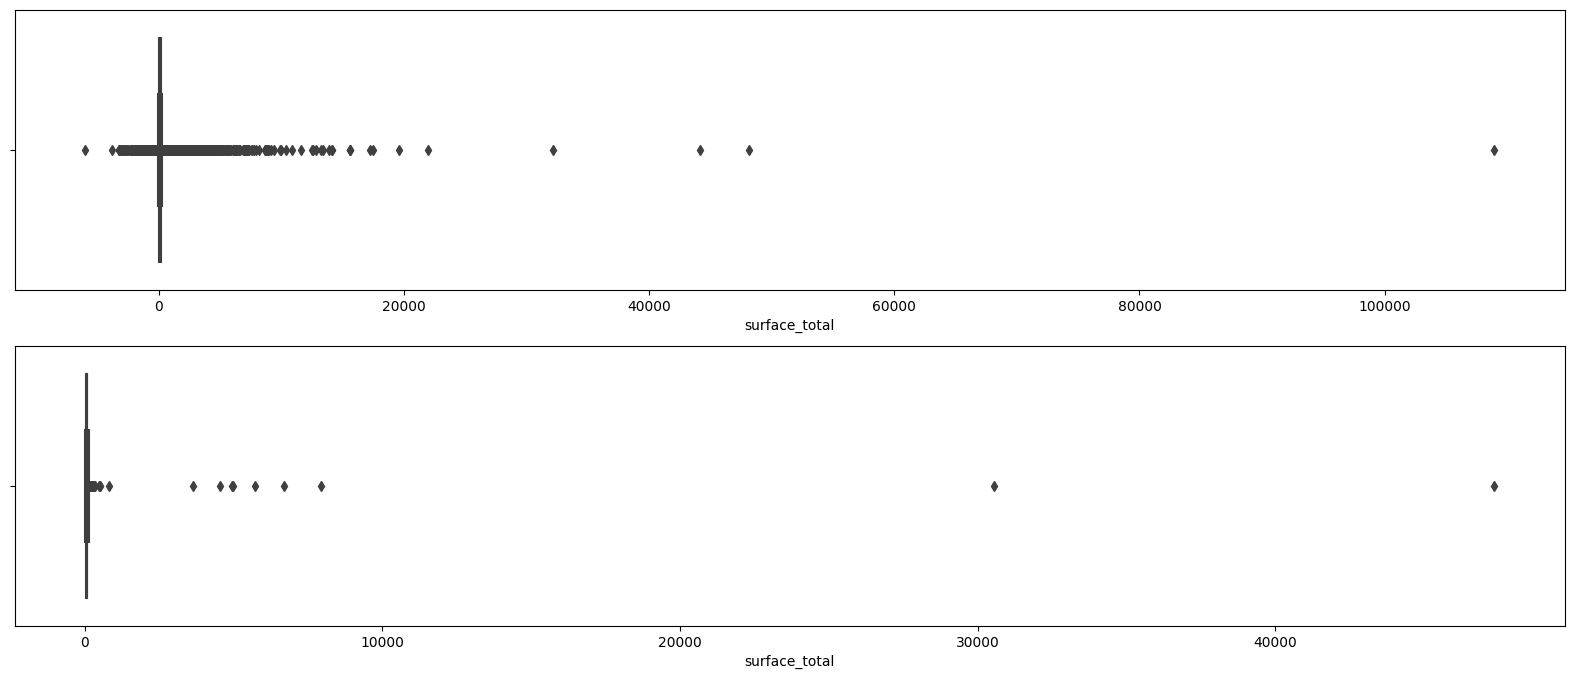

In [581]:
fig, ax = plt.subplots(nrows=2,figsize=(20,8))
sns.boxplot(data=df_train,x='surface_total',ax=ax[0])
sns.boxplot(data=df_test,x='surface_total',ax=ax[1])

In [582]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,100591.0,85.257393,207.768667,20.000000,41.044627,62.0,100.0,31550.0
surface_total,100591.0,146.328567,580.711035,-6008.880032,43.000000,70.0,130.0,108960.0


In [583]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [584]:
df_train = df_train[((df_train['surface_total']>=10)&(df_train['surface_total']<50000))|(df_train['surface_total'].isnull())]
df_train.shape

(95914, 31)

In [585]:
df_train[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,95914.0,82.577618,212.001841,20.0,41.0,60.0,91.0,31550.0
surface_total,95914.0,169.079044,457.650534,12.0,46.0,73.0,138.0,48170.0


In [586]:
df_test[['surface_covered','surface_total']].describe().T

,count,mean,std,min,25%,50%,75%,max
surface_covered,6000.0,76.894979,672.776879,10.0,45.0,59.000000,76.738295,47360.0
surface_total,6000.0,91.262284,751.427838,21.0,51.0,67.796492,91.032708,47360.0


In [587]:
df_train.price.value_counts().sort_index()

5000.0        1
9500.0        1
10000.0       5
10500.0       2
11111.0       1
             ..
9477000.0     3
11111111.0    1
12345678.0    1
15011160.0    1
32434232.0    1
Name: price, Length: 6371, dtype: int64

## Imputación de nulos

## Armado de variables

In [588]:
df = pd.concat((df_train,df_test),axis=0)

df['bathrooms_rooms'] = df['bathrooms']/df['rooms']
df['bedrooms_rooms'] = df['bedrooms']/df['rooms']
df['covered'] = df['surface_covered']/df['surface_total']

df['start_year']  = pd.to_datetime(df['start_date']).dt.year
df['start_month'] = pd.to_datetime(df['start_date']).dt.month
df['start_day'] = pd.to_datetime(df['start_date']).dt.month

df['tiene_esp_abierto'] = 0
df.loc[(df['surface_total']-df['surface_covered'])!=0,'tiene_esp_abierto'] = 1

df['description'] = df["description"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')
#df['title'] = df["title"].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')

for c in ["barrio privado", "corredor",'suite','monoambiente','amueblado',
          'ascensor','parrilla','patio','balcon','jardin','linea (a|b|b|c|d|e|h)',
          'obelisco','catedral','metrobus','barrancas','barrio chino','river',
          'universidad','facultad','subte','tren','estacion','museo','parque','jacuzzi',
          '(j|y)acu(z|zz)i','sho(pp|p)ing','country','terminal','avenida','av.','av',
          'expensa','expensas','a(mm|m)enities','inmobiliaria','dueñ(o|a) direct(o|a)',
          'balcon','pileta|piscina','escuela|colegio','centro','microcentro','lago','libertador']:
    df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
    #df[f"title_{c}"] = df["title"].str.contains(c,regex=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13500\2744056837.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13500\2744056837.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13500\2744056837.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df[f"desc_{c}"] = df["description"].str.contains(c,regex=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13500\2744056837.py:24: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.ex

In [589]:
df.covered.value_counts(dropna=False).sort_index()

0.000851     1
0.004233     1
0.004679     1
0.005105     1
0.007350     1
            ..
19.352209    2
20.143609    1
21.003826    2
24.100608    1
26.738608    1
Name: covered, Length: 5677, dtype: int64

In [590]:
# from sklearn.preprocessing import LabelEncoder

# labelencoder = LabelEncoder()

# df['l3'] = labelencoder.fit_transform(df['l3'])

In [591]:
df_train = df[~df.price.isnull()]
df_test = df[df.price.isnull()]

## Selección de atributos

In [592]:
cols = ['l1','l5','l6','ad_type','currency','operation_type']
df_train.drop(cols,inplace=True,axis=1)
df_test.drop(cols,inplace=True,axis=1)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_13500\2438721469.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(cols,inplace=True,axis=1)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_13500\2438721469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(cols,inplace=True,axis=1)


## Dummies

In [593]:
cols_dummies = ['l2','l3','l4','property_type']
train_dummies = pd.get_dummies(df_train[cols_dummies],dummy_na=True)
df_train = pd.concat((df_train,train_dummies),axis=1)

test_dummies = pd.get_dummies(df_test[cols_dummies],dummy_na=True)
df_test = pd.concat((df_test,test_dummies),axis=1)

In [594]:
cols = pd.concat((df_train,df_test),axis=0,join='inner').columns

df_train = df_train[cols]
df_test = df_test[cols]

## Borrado por varianza

In [595]:
from sklearn.feature_selection import VarianceThreshold

In [596]:
# F = df_train[~df_train.price.isnull()]
# X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
# y = F['price']

# print(X.shape)
# fs = VarianceThreshold(threshold=0.005)
# X_new = fs.fit_transform(X) # threshold = limite superior de la varianza
# print(X_new.shape)

# cols = list(X.columns[fs.get_support()])
# cols.append('price')

# df_train = df_train[cols]
# df_test = df_test[cols]

In [597]:
df_train.loc[((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))&(df_train.lat<-58.42),'lat'] = -58.361

In [598]:
df_test.loc[((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))&(df_test.lat<-58.4),'lat'] = -58.361

<AxesSubplot: xlabel='lat', ylabel='lon'>

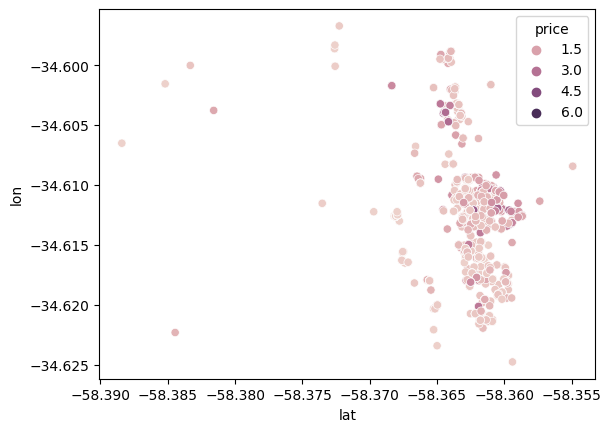

In [599]:
sns.scatterplot(data=df_train[(df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas')],x='lat',y='lon',hue='price')

In [600]:
# df_test['lat'], df_test['lon'] = df_test['lon'], df_test['lat']
# df_train['lat'], df_train['lon'] = df_train['lon'], df_train['lat']
from shapely.geometry import Point
df_test['punto'] = df_test.apply(lambda row: Point(row['lat'], row['lon']), axis=1)
df_train['punto'] = df_train.apply(lambda row: Point(row['lat'], row['lon']), axis=1)

## División de base

In [601]:
df_test_la_plata = df_test[(df_test.lat>-58.2)&(df_test.lon<-34.8)]
df_train_la_plata = df_train[(df_train.lat>-58.2)&(df_train.lon<-34)]

df_test_caba = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&~((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]
df_train_caba = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&~((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]

In [602]:
df_test_madero = df_test[(df_test.lat<=-58.2)&(df_test.lon>=-34.8)&((df_test.l3=='Puerto Madero')|(df_test.l3=='Catalinas'))]

df_train_madero = df_train[~((df_train.lat>-58.2)&(df_train.lon<-34))&((df_train.l3=='Puerto Madero')|(df_train.l3=='Catalinas'))]

corredor_norte = ['Retiro','Recoleta','Barrio Norte']#,'Nuñez','Distrito Audiovisual','Palermo','Belgrano','Coghlan','Las Cañitas',]

df_train_corredor_norte = df_train_caba[df_train_caba.l3.isin(corredor_norte)]
df_test_corredor_norte = df_test_caba[df_test_caba.l3.isin(corredor_norte)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(corredor_norte)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(corredor_norte)]

corredor_sur = ['Villa Riachuelo','Villa Lugano','Villa Soldati','Pompeya','Boca','Constitución']#'Barracas','Parque Patricios']

df_train_corredor_sur = df_train_caba[df_train_caba.l3.isin(corredor_sur)]
df_test_corredor_sur = df_test_caba[df_test_caba.l3.isin(corredor_sur)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(corredor_sur)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(corredor_sur)]

caballito = ['Almagro','Caballito','Parque Centenario','Villa Crespo']

df_train_caballito = df_train_caba[df_train_caba.l3.isin(caballito)]
df_test_caballito= df_test_caba[df_test_caba.l3.isin(caballito)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(caballito)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(caballito)]

palermo = ['Palermo','Distrito Audiovisual','Las Cañitas']
df_train_palermo = df_train_caba[df_train_caba.l3.isin(palermo)]
df_test_palermo= df_test_caba[df_test_caba.l3.isin(palermo)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(palermo)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(palermo)]

belgrano = ['Belgrano','Nuñez','Coghlan']
df_train_belgrano = df_train_caba[df_train_caba.l3.isin(belgrano)]
df_test_belgrano= df_test_caba[df_test_caba.l3.isin(belgrano)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(belgrano)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(belgrano)]


noroeste = ['Saavedra','Villa Ortuzar','Villa Urquiza']#,'Coghlan']

df_train_noroeste = df_train_caba[df_train_caba.l3.isin(noroeste)]
df_test_noroeste= df_test_caba[df_test_caba.l3.isin(noroeste)]

df_train_caba = df_train_caba[~df_train_caba.l3.isin(noroeste)]
df_test_caba = df_test_caba[~df_test_caba.l3.isin(noroeste)]

# centro = ['San Cristobal','Balvanera','San Nicolás','Monserrat','Congreso','San Telmo','Once','Tribunales','Abasto','Centro / Microcentro']

# df_train_centro = df_train_caba[df_train_caba.l3.isin(centro)]
# df_test_centro= df_test_caba[df_test_caba.l3.isin(centro)]

# df_train_caba = df_train_caba[~df_train_caba.l3.isin(centro)]
# df_test_caba = df_test_caba[~df_test_caba.l3.isin(centro)]

df_train_devoto = df_train_caba[df_train_caba.l3=='Villa Devoto']
df_test_devoto = df_test_caba[df_test_caba.l3=='Villa Devoto']

df_train_caba = df_train_caba[df_train_caba.l3!='Villa Devoto']
df_test_caba= df_test_caba[df_test_caba.l3!='Villa Devoto']

df_train_barracas = df_train_caba[df_train_caba.l3=='Barracas']
df_test_barracas = df_test_caba[df_test_caba.l3=='Barracas']

df_train_caba = df_train_caba[df_train_caba.l3!='Barracas']
df_test_caba= df_test_caba[df_test_caba.l3!='Barracas']

In [603]:
df_train_palermo.price.max()

32434232.0

In [604]:
# df_train_palermo['price_cut'] = pd.cut(df_train_palermo['price'],bins=10)
# df_train_palermo.price_cut.value_counts(dropna=False).sort_index()

In [605]:
df_train_palermo.loc[df_train_palermo.price==32434232,'price'] = 32434232/10

In [606]:
# df_train_palermo['price_cut'] = pd.cut(df_train_palermo['price'],bins=5)
# sns.scatterplot(data=df_train_palermo[df_train_palermo.price_cut!=df_train_palermo.price_cut.min()],x='lat',y='lon',hue='l3')

In [607]:
# df_train_belgrano['price_cut'] = pd.cut(df_train_belgrano['price'],bins=5)
# sns.scatterplot(data=df_train_belgrano[df_train_belgrano.price_cut!=df_train_belgrano.price_cut.min()],x='lat',y='lon',hue='price_cut')

<AxesSubplot: xlabel='price', ylabel='l3'>

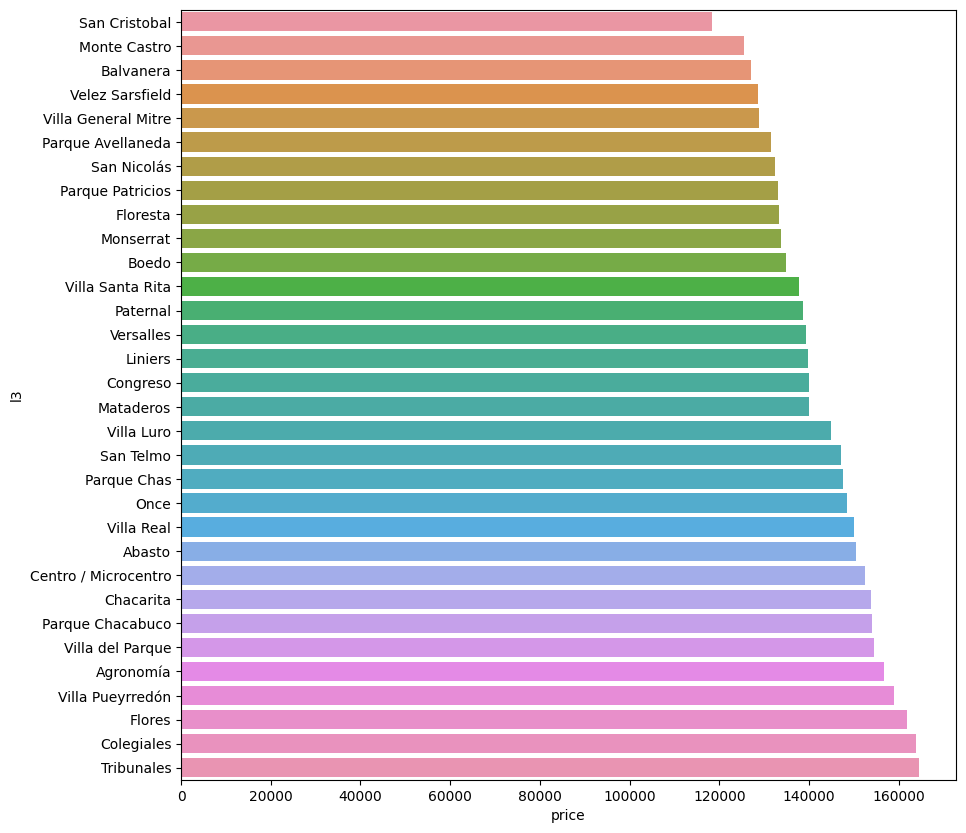

In [608]:
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(data=df_train_caba.groupby('l3').agg({'price':'mean'}).reset_index().sort_values('price'),y='l3',x='price')

In [609]:
def filtrado_columnas(df_test,df_train):
    F = df_train[~df_train.price.isnull()]
    X = F[F.select_dtypes(include=['float64' ,'float32','int64', 'int32', 'int16', 'int8', 'bool','uint8']).columns.drop('price')]
    y = F['price']

    clf = sk.ensemble.RandomForestRegressor(n_estimators=50, n_jobs=-1,random_state=42)
    clf.fit(X, y)

    importancias = pd.DataFrame({'atributo': clf.feature_names_in_, 'importancia': clf.feature_importances_})
    cols = list(importancias[importancias['importancia']>0.0001].sort_values('importancia',ascending=False).reset_index(drop=True).atributo)

    cols.append('price')

    display(importancias.sort_values('importancia').tail(10))

    df_train = df_train[cols]
    df_test = df_test[cols]

    print(df_train.shape)
    return df_test, df_train

In [610]:
import spacy
import locale
locale.getpreferredencoding = lambda: "UTF-8"
# spacy.cli.download("es_core_news_sm")
from sklearn.feature_extraction.text import CountVectorizer
nlp = spacy.load("es_core_news_sm")
stopwords = nlp.Defaults.stop_words

In [611]:
def tokenizacion(df_test,df_train,columna):
    df = pd.concat((df_test,df_train),axis=0)
    
    df[columna] = df[columna].fillna('NA')

    nlp = spacy.load("es_core_news_sm")
    stopwords = nlp.Defaults.stop_words

    df[columna+'_tok'] = df[columna].apply(lambda texto: [token.text for token in nlp(texto)])
    df[columna+'_tok'] = df[columna+'_tok'].apply(lambda texto: [token for token in texto if token not in stopwords])
    df[columna] = df[columna+'_tok'].str.join(' ')

    vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000)
    vectorized_data = vectorizer.fit_transform(df[columna])

    count_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat((df,count_df),axis=1)

    df_train = df[~df.price.isnull()]
    df_test = df[df.price.isnull()]

    return df_test, df_train

In [612]:
from joblib import Parallel, delayed

def tokenize_text(text):
    nlp = spacy.load("es_core_news_sm")
    stopwords = nlp.Defaults.stop_words
    doc = nlp(text)
    tokens = [token.text for token in doc if token.text not in stopwords]
    return ' '.join(tokens)

def tokenizacion(df_test, df_train, columna):
    df = pd.concat((df_test, df_train), axis=0)

    df[columna] = df[columna].fillna('NA')

    # Tokenización en paralelo
    df[columna + '_tok'] = Parallel(n_jobs=-1)(delayed(tokenize_text)(text) for text in df[columna])

    vectorizer = CountVectorizer(ngram_range=(1, 3), min_df=0.005, max_df=0.7, strip_accents='ascii', max_features=2000)
    vectorized_data = vectorizer.fit_transform(df[columna + '_tok'])

    count_df = pd.DataFrame(vectorized_data.toarray(), columns=vectorizer.get_feature_names_out(), index=df.index)

    df = pd.concat((df, count_df), axis=1)

    df_train = df[~df.price.isnull()]
    df_test = df[df.price.isnull()]

    return df_test, df_train

In [613]:
df_train_madero = pd.concat((df_train_madero,df_train_caba[(df_train_caba.title.fillna('NA').str.contains(' PUERTO MADERO'))]),axis=0)
df_train_caba = df_train_caba[~(df_train_caba.title.fillna('NA').str.contains(' PUERTO MADERO'))]

In [614]:
df_train_barracas = df_train_barracas[~df_train_barracas.title.str.contains('600000')]

df_train_belgrano = pd.concat((df_train_belgrano,df_train_barracas[df_train_barracas.title.str.contains('Barrancas')]),axis=0)

df_train_barracas = df_train_barracas[~df_train_barracas.title.str.contains('Barrancas')]

df_train_devoto = df_train_devoto[df_train_devoto.price<2215000]

In [615]:
print(f"La plata tiene {df_train_la_plata.shape[0]} en train y {df_test_la_plata.shape[0]} en test")
print(f"CABA tiene {df_train_caba.shape[0]} en train y {df_test_caba.shape[0]} en test")
print(f"Pto Madero y Catalinas tiene {df_train_madero.shape[0]} en train y {df_test_madero.shape[0]} en test")
print(f"Corr norte tiene {df_train_corredor_norte.shape[0]} en train y {df_test_corredor_norte.shape[0]} en test")
print(f"Corr sur tiene {df_train_corredor_sur.shape[0]} en train y {df_test_corredor_sur.shape[0]} en test")
print(f"Caballito tiene {df_train_caballito.shape[0]} en train y {df_test_caballito.shape[0]} en test")
print(f"Palermo tiene {df_train_palermo.shape[0]} en train y {df_test_palermo.shape[0]} en test")
print(f"Belgrano tiene {df_train_belgrano.shape[0]} en train y {df_test_belgrano.shape[0]} en test")
print(f"Noroeste tiene {df_train_noroeste.shape[0]} en train y {df_test_noroeste.shape[0]} en test")
print(f"Devoto tiene {df_train_devoto.shape[0]} en train y {df_test_devoto.shape[0]} en test")
print(f"Barracas tiene {df_train_barracas.shape[0]} en train y {df_test_barracas.shape[0]} en test")


La plata tiene 60 en train y 264 en test
CABA tiene 26364 en train y 1787 en test
Pto Madero y Catalinas tiene 1467 en train y 100 en test
Corr norte tiene 8622 en train y 428 en test
Corr sur tiene 1703 en train y 111 en test
Caballito tiene 24363 en train y 1373 en test
Palermo tiene 15207 en train y 875 en test
Belgrano tiene 10679 en train y 576 en test
Noroeste tiene 5242 en train y 346 en test
Devoto tiene 1401 en train y 90 en test
Barracas tiene 804 en train y 50 en test


In [616]:
fraccion = .5
print("La Plata")
df_test_la_plata, df_train_la_plata             = tokenizacion(df_test_la_plata,df_train_la_plata,'description')
# print("Resto de Caba")
# df_test_caba_txt, df_train_caba_txt                     = tokenizacion(df_test_caba.sample(frac=fraccion,random_state=42),df_train_caba.sample(frac=fraccion,random_state=42),'description')
print("Madero y Catalinas")
df_test_madero, df_train_madero                 = tokenizacion(df_test_madero,df_train_madero,'description')
# print("Corredor Norte")
# df_test_corredor_norte, df_train_corredor_norte = tokenizacion(df_test_corredor_norte,df_train_corredor_norte,'description')
print("Corredor sur")
df_test_corredor_sur, df_train_corredor_sur     = tokenizacion(df_test_corredor_sur,df_train_corredor_sur,'description')
# print("Caballito")
# df_test_caballito_txt, df_train_caballito_txt          = tokenizacion(df_test_caballito.sample(frac=fraccion,random_state=42),df_train_caballito.sample(frac=fraccion,random_state=42),'description')
print("Devoto")
df_test_devoto, df_train_devoto = tokenizacion(df_test_devoto,df_train_devoto,'description')
print("Barracas")
df_test_barracas, df_train_barracas = tokenizacion(df_test_barracas,df_train_barracas,'description')

La Plata
Madero y Catalinas
Corredor sur
Devoto
Barracas


In [617]:
# for c in df_train_caba_txt.columns:
#     df_train_caba[f"desc_{c}"] = df_train_caba["description"].str.contains(c,regex=True)
#     df_test_caba[f"desc_{c}"] = df_test_caba["description"].str.contains(c,regex=True)

# for c in df_train_corredor_norte_txt.columns:
#     df_train_corredor_norte[f"desc_{c}"] = df_train_corredor_norte["description"].str.contains(c,regex=True)
#     df_test_corredor_norte[f"desc_{c}"] = df_test_corredor_norte["description"].str.contains(c,regex=True)

# for c in df_train_caballito_txt.columns:
#     df_train_caballito[f"desc_{c}"] = df_train_caballito["description"].str.contains(c,regex=True)
#     df_test_caballito[f"desc_{c}"] = df_test_caballito["description"].str.contains(c,regex=True)

In [618]:
# df_train_caba.drop(columns=['desc_del','desc_en'],inplace=True)
# df_test_caba.drop(columns=['desc_del','desc_en'],inplace=True)

In [619]:
print("La Plata")
df_test_la_plata, df_train_la_plata = filtrado_columnas(df_test_la_plata,df_train_la_plata)
print("Resto de Caba")
df_test_caba, df_train_caba = filtrado_columnas(df_test_caba,df_train_caba)
print("Madero y Catalinas")
df_test_madero, df_train_madero = filtrado_columnas(df_test_madero,df_train_madero)
print("Corredor Norte")
df_test_corredor_norte, df_train_corredor_norte = filtrado_columnas(df_test_corredor_norte,df_train_corredor_norte)
print("Corredor sur")
df_test_corredor_sur, df_train_corredor_sur = filtrado_columnas(df_test_corredor_sur,df_train_corredor_sur)
print("Caballito")
df_test_caballito, df_train_caballito = filtrado_columnas(df_test_caballito,df_train_caballito)
print("Palermo")
df_test_palermo, df_train_palermo = filtrado_columnas(df_test_palermo,df_train_palermo)
print("Belgrano")
df_test_belgrano, df_train_belgrano = filtrado_columnas(df_test_belgrano,df_train_belgrano)
print("Noroeste")
df_test_noroeste, df_train_noroeste = filtrado_columnas(df_test_noroeste,df_train_noroeste)
# print("Centro")
# df_test_centro, df_train_centro = filtrado_columnas(df_test_centro,df_train_centro)
print("Devoto")
df_test_devoto, df_train_devoto = filtrado_columnas(df_test_devoto,df_train_devoto)
print("Barracas")
df_test_barracas, df_train_barracas = filtrado_columnas(df_test_barracas,df_train_barracas)

La Plata


,atributo,importancia
1,lon,0.018414
1485,m2 cubiertos,0.021146
521,barrio,0.024441
1571,mts,0.024689
205,25,0.025029
513,bano dormitorio,0.031736
1687,pasillo,0.051961
6,surface_total,0.053404
1060,dormitorio,0.095777
7,surface_covered,0.283094


(60, 207)
Resto de Caba


,atributo,importancia
19,start_day,0.020381
60,desc_centro,0.021187
18,start_month,0.022716
16,covered,0.024288
11,surface_covered_imputed,0.027928
5,surface_total,0.044341
0,lat,0.068522
1,lon,0.071825
4,bathrooms,0.074293
6,surface_covered,0.394778


(26364, 88)
Madero y Catalinas


,atributo,importancia
1103,guardado,0.003520
1,lon,0.003574
16,covered,0.003869
0,lat,0.003939
992,excelentes,0.004325
319,amoblado,0.005333
293,alvear,0.005826
622,cocheras,0.007409
5,surface_total,0.013869
6,surface_covered,0.815681


(1467, 229)
Corredor Norte


,atributo,importancia
23,desc_suite,0.007354
15,bedrooms_rooms,0.007455
58,desc_pileta|piscina,0.007607
14,bathrooms_rooms,0.008097
11,surface_covered_imputed,0.012360
16,covered,0.026433
0,lat,0.038756
1,lon,0.080773
5,surface_total,0.136527
6,surface_covered,0.607726


(8622, 52)
Corredor sur


,atributo,importancia
420,ambientes pisos,0.016711
1147,frente,0.017517
2081,venta,0.021592
0,lat,0.023801
18,start_month,0.023925
577,br apto,0.026878
5,surface_total,0.034458
1,lon,0.081205
6,surface_covered,0.136726
4,bathrooms,0.150845


(1703, 435)
Caballito


,atributo,importancia
18,start_month,0.013585
16,covered,0.014335
4,bathrooms,0.014352
8,bedrooms_imputed,0.016062
40,desc_subte,0.020283
60,desc_centro,0.037478
5,surface_total,0.064593
6,surface_covered,0.157154
1,lon,0.166407
0,lat,0.400405


(24363, 53)
Palermo


,atributo,importancia
14,bathrooms_rooms,0.011330
58,desc_pileta|piscina,0.012289
11,surface_covered_imputed,0.015159
23,desc_suite,0.016607
16,covered,0.017085
1,lon,0.032383
5,surface_total,0.049549
55,desc_a(mm|m)enities,0.053430
0,lat,0.062022
6,surface_covered,0.660620


(15207, 55)
Belgrano


,atributo,importancia
14,bathrooms_rooms,0.014825
16,covered,0.021915
4,bathrooms,0.022980
11,surface_covered_imputed,0.029343
5,surface_total,0.041245
58,desc_pileta|piscina,0.043544
55,desc_a(mm|m)enities,0.048209
0,lat,0.063810
1,lon,0.071317
6,surface_covered,0.536832


(10679, 55)
Noroeste


,atributo,importancia
14,bathrooms_rooms,0.018403
16,covered,0.023778
0,lat,0.026050
7,rooms_imputed,0.027314
1,lon,0.029418
4,bathrooms,0.042824
23,desc_suite,0.048439
5,surface_total,0.107615
6,surface_covered,0.219578
2,rooms,0.296349


(5242, 55)
Devoto


,atributo,importancia
731,categoria,0.011149
2008,toilette,0.011629
0,lat,0.013667
16,covered,0.014929
1,lon,0.019693
23,desc_suite,0.042080
2,rooms,0.044442
4,bathrooms,0.058956
5,surface_total,0.070457
6,surface_covered,0.429541


(1401, 421)
Barracas


,atributo,importancia
1955,suite vestidor,0.008076
552,baulera,0.008992
16,covered,0.012576
14,bathrooms_rooms,0.020529
58,desc_pileta|piscina,0.022543
1,lon,0.030345
0,lat,0.034919
4,bathrooms,0.040235
5,surface_total,0.101702
6,surface_covered,0.472760


(804, 367)


# Entrenamiento del modelo

## Territorio de Aprendizaje Automático
☢☢☢☢☢☢ Se mira y no se toca ☢☢☢☢☢☢☢

In [620]:
# Funcion de limpieza (usada en la siguiente sección) que usa y_train
def limpiar_fold(X_train, y_train, X_test):
    ## TODO: limpiar los datos           
    
    return (X_train, y_train, X_test)

In [621]:
def modelado(df_train,df_test):
    # Datos para probar
    df_train = df_train.select_dtypes(include=['float64', 'int64', 'int32', 'int16', 'int8', 'bool'])

    X = df_train[df_train.columns.drop('price')]
    y = df_train['price']

    # Creamos el modelo
    reg = sk.ensemble.RandomForestRegressor(n_estimators=500, max_depth=5, n_jobs=-1, random_state=42)

    # Partimos en entrenamiento+prueba y validación
    X_train_test, X_val, y_train_test, y_val = sk.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

    scores_train = []
    scores_test = []
    # Validación cruzada, 10 folds, shuffle antes
    kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kf.split(X_train_test, y_train_test)):
        X_train, X_test, y_train, y_test = X_train_test.iloc[train_index], X_train_test.iloc[test_index], y_train_test.iloc[train_index], y_train_test.iloc[test_index]

        X_train, y_train, X_test = limpiar_fold(X_train, y_train, X_test)

        # Entrenamos el modelo
        reg.fit(X_train, y_train)

        # Predecimos en train
        y_pred = reg.predict(X_train)

        # Medimos la performance de la predicción en test
        score_train = sk.metrics.mean_squared_error(y_train, y_pred,squared=False).round()
        scores_train.append(score_train)

        # Predecimos en test
        y_pred = reg.predict(X_test)    

        # Medimos la performance de la predicción en test
        score_test = sk.metrics.mean_squared_error(y_test, y_pred,squared=False).round()
        scores_test.append(score_test)
        
        print(f"{fold=}, {score_train=} {score_test=}")
        

    print(f"Train scores mean={pd.Series(scores_train).mean()}, std={pd.Series(scores_train).std()}")
    print(f"Test scores mean={pd.Series(scores_test).mean()}, std={pd.Series(scores_test).std()}")

    ## Datos a predecir 
    X = df_train[df_train.columns.drop('price')]
    y = df_train['price']
    X_prueba = df_test[df_train.columns.drop('price')] # cuidado:

    # Entrenamos el modelo con todos los datos
    reg.fit(X, y)

    # Predecimos
    df_test['price'] = reg.predict(X_prueba)

    # Grabamos
    # df_test['price'].to_csv('solucion_la_plata.csv', index=True)

    display(pd.DataFrame(zip(df_train.columns.drop('price'), 
                             reg.feature_importances_*100), 
                         columns=["column", "feature_importance"]).sort_values(by="feature_importance", ascending=False).head(10))

    return df_test['price']

In [622]:
print("Resto de CABA")
solucion_caba = modelado(df_train_caba,df_test_caba)
print("La Plata")
solucion_la_plata = modelado(df_train_la_plata,df_test_la_plata)
print("Puerto Madero y Catalinas")
solucion_madero = modelado(df_train_madero,df_test_madero)
print("Corredor Norte")
solucion_corredor_norte = modelado(df_train_corredor_norte,df_test_corredor_norte)
print("Corredor Sur")
solucion_corredor_sur = modelado(df_train_corredor_sur,df_test_corredor_sur)
print("Caballito")
solucion_caballito = modelado(df_train_caballito,df_test_caballito)
print("Palermo")
solucion_palermo= modelado(df_train_palermo,df_test_palermo)
print("Belgrano")
solucion_belgrano = modelado(df_train_belgrano,df_test_belgrano)
print("Noroeste")
solucion_noroeste = modelado(df_train_noroeste,df_test_noroeste)
# print("Centro")
# solucion_centro = modelado(df_train_centro,df_test_centro)
print("devoto")
solucion_devoto = modelado(df_train_devoto,df_test_devoto)
print("Barracas")
solucion_barracas = modelado(df_train_barracas,df_test_barracas)

Resto de CABA
fold=0, score_train=57144.0 score_test=102726.0
fold=1, score_train=64406.0 score_test=44775.0
fold=2, score_train=64196.0 score_test=50069.0
fold=3, score_train=63853.0 score_test=48847.0
fold=4, score_train=56175.0 score_test=113285.0
fold=5, score_train=63302.0 score_test=56763.0
fold=6, score_train=63796.0 score_test=48367.0
fold=7, score_train=63168.0 score_test=60796.0
fold=8, score_train=63732.0 score_test=51634.0
fold=9, score_train=63884.0 score_test=48703.0
Train scores mean=62365.6, std=3037.797308723689
Test scores mean=62596.5, std=24486.389898835187


,column,feature_importance
0,surface_covered,63.172911
1,bathrooms,12.035819
5,surface_covered_imputed,4.618923
2,lon,4.602246
3,lat,4.249114
4,surface_total,3.473518
10,desc_pileta|piscina,1.422879
11,desc_suite,1.358948
12,bathrooms_imputed,1.215960
6,covered,0.753700


La Plata
fold=0, score_train=8346.0 score_test=61895.0
fold=1, score_train=9683.0 score_test=17951.0
fold=2, score_train=10782.0 score_test=22145.0
fold=3, score_train=10557.0 score_test=26851.0
fold=4, score_train=10878.0 score_test=12885.0
fold=5, score_train=9686.0 score_test=36190.0
fold=6, score_train=10396.0 score_test=24265.0
fold=7, score_train=10916.0 score_test=7963.0
fold=8, score_train=11038.0 score_test=9939.0
fold=9, score_train=10731.0 score_test=7800.0
Train scores mean=10301.3, std=838.4720296136566
Test scores mean=22788.4, std=16529.628437041974


,column,feature_importance
0,surface_covered,25.946017
3,pasillo,7.545956
4,bano dormitorio,6.447043
1,dormitorio,6.303504
2,surface_total,5.713129
10,rooms,3.274841
9,lon,2.955651
6,mts,2.289604
19,bathrooms,1.884629
5,25,1.686467


Puerto Madero y Catalinas
fold=0, score_train=177258.0 score_test=188945.0
fold=1, score_train=178295.0 score_test=179528.0
fold=2, score_train=167463.0 score_test=391614.0
fold=3, score_train=179064.0 score_test=193279.0
fold=4, score_train=164313.0 score_test=462404.0
fold=5, score_train=176084.0 score_test=214591.0
fold=6, score_train=178538.0 score_test=168774.0
fold=7, score_train=182353.0 score_test=154807.0
fold=8, score_train=174967.0 score_test=251962.0
fold=9, score_train=176247.0 score_test=305717.0
Train scores mean=175458.2, std=5484.379409843115
Test scores mean=251162.1, std=103863.78271397376


,column,feature_importance
0,surface_covered,86.049065
2,cocheras,0.907333
1,surface_total,0.865996
5,excelentes,0.743594
3,alvear,0.505626
4,amoblado,0.494175
12,real,0.416792
10,diario,0.374515
7,covered,0.314083
11,semi integrada,0.312224


Corredor Norte
fold=0, score_train=117253.0 score_test=130482.0
fold=1, score_train=118562.0 score_test=110403.0
fold=2, score_train=116668.0 score_test=125707.0
fold=3, score_train=116555.0 score_test=143606.0
fold=4, score_train=110397.0 score_test=212616.0
fold=5, score_train=118549.0 score_test=108496.0
fold=6, score_train=118423.0 score_test=119077.0
fold=7, score_train=115999.0 score_test=141118.0
fold=8, score_train=116004.0 score_test=139455.0
fold=9, score_train=117810.0 score_test=117216.0
Train scores mean=116622.0, std=2405.0252481927178
Test scores mean=134817.6, std=30072.70842179371


,column,feature_importance
0,surface_covered,70.910924
1,surface_total,14.353176
2,lon,6.214488
4,covered,2.204862
3,lat,1.793378
5,surface_covered_imputed,1.245715
7,desc_pileta|piscina,0.619497
10,desc_a(mm|m)enities,0.471110
6,bathrooms_rooms,0.399681
9,desc_suite,0.397119


Corredor Sur
fold=0, score_train=29371.0 score_test=70144.0
fold=1, score_train=30459.0 score_test=40532.0
fold=2, score_train=31454.0 score_test=32802.0
fold=3, score_train=26688.0 score_test=94519.0
fold=4, score_train=30868.0 score_test=33175.0
fold=5, score_train=30389.0 score_test=39670.0
fold=6, score_train=31529.0 score_test=26654.0
fold=7, score_train=31361.0 score_test=36513.0
fold=8, score_train=31412.0 score_test=25313.0
fold=9, score_train=29972.0 score_test=33830.0
Train scores mean=30350.3, std=1473.9258273211867
Test scores mean=43315.2, std=21893.45943325439


,column,feature_importance
0,bathrooms,19.609814
1,surface_covered,16.639149
2,lon,8.238512
4,br apto,3.825935
3,surface_total,3.010455
11,balcon frente,2.646699
7,venta,2.304358
12,bano ducha,2.097583
6,lat,1.640658
16,115,1.625756


Caballito
fold=0, score_train=129279.0 score_test=126278.0
fold=1, score_train=123956.0 score_test=51574.0
fold=2, score_train=61644.0 score_test=341422.0
fold=3, score_train=124990.0 score_test=90670.0
fold=4, score_train=128192.0 score_test=57988.0
fold=5, score_train=130275.0 score_test=119973.0
fold=6, score_train=126781.0 score_test=70607.0
fold=7, score_train=125555.0 score_test=84634.0
fold=8, score_train=126366.0 score_test=66521.0
fold=9, score_train=125080.0 score_test=44356.0
Train scores mean=120211.8, std=20676.021677295656
Test scores mean=105402.3, std=87303.10083973726


,column,feature_importance
0,lat,37.690279
2,surface_covered,23.622087
4,desc_centro,9.348639
3,surface_total,6.959744
6,bedrooms_imputed,6.084620
11,desc_avenida,3.665711
1,lon,3.104603
5,desc_subte,3.069626
7,bathrooms,2.156346
12,desc_estacion,1.605793


Palermo
fold=0, score_train=148246.0 score_test=140499.0
fold=1, score_train=144705.0 score_test=177574.0
fold=2, score_train=150458.0 score_test=145375.0
fold=3, score_train=148704.0 score_test=177202.0
fold=4, score_train=149984.0 score_test=160735.0
fold=5, score_train=147555.0 score_test=181496.0
fold=6, score_train=142487.0 score_test=226015.0
fold=7, score_train=149959.0 score_test=139900.0
fold=8, score_train=147434.0 score_test=153400.0
fold=9, score_train=149387.0 score_test=159755.0
Train scores mean=147891.9, std=2537.437922612317
Test scores mean=166195.1, std=25998.653291832037


,column,feature_importance
0,surface_covered,76.459466
2,desc_a(mm|m)enities,5.798691
1,lat,4.746817
3,surface_total,3.646968
6,desc_suite,1.965267
7,surface_covered_imputed,1.815052
4,lon,1.688994
8,desc_pileta|piscina,1.112346
5,covered,0.674554
9,bathrooms_rooms,0.433848


Belgrano
fold=0, score_train=154800.0 score_test=138861.0
fold=1, score_train=151583.0 score_test=147341.0
fold=2, score_train=133609.0 score_test=393746.0
fold=3, score_train=145545.0 score_test=206789.0
fold=4, score_train=150907.0 score_test=170505.0
fold=5, score_train=153186.0 score_test=137211.0
fold=6, score_train=153214.0 score_test=146705.0
fold=7, score_train=153493.0 score_test=157160.0
fold=8, score_train=149211.0 score_test=165690.0
fold=9, score_train=147074.0 score_test=198101.0
Train scores mean=149262.2, std=6247.687515304274
Test scores mean=186210.9, std=76639.10832444925


,column,feature_importance
0,surface_covered,66.170254
3,desc_a(mm|m)enities,6.967489
1,lon,4.333505
4,desc_pileta|piscina,4.234964
2,lat,3.904456
6,surface_covered_imputed,3.399520
5,surface_total,2.780392
7,bathrooms,1.350536
9,bathrooms_rooms,1.216850
12,desc_suite,1.034647


Noroeste
fold=0, score_train=59511.0 score_test=47435.0
fold=1, score_train=58059.0 score_test=53952.0
fold=2, score_train=58666.0 score_test=45018.0
fold=3, score_train=61341.0 score_test=44356.0
fold=4, score_train=57955.0 score_test=55239.0
fold=5, score_train=57842.0 score_test=56156.0
fold=6, score_train=58671.0 score_test=50521.0
fold=7, score_train=59133.0 score_test=62064.0
fold=8, score_train=43410.0 score_test=181799.0
fold=9, score_train=59790.0 score_test=56257.0
Train scores mean=57437.8, std=5039.454000407408
Test scores mean=65279.7, std=41319.16654007758


,column,feature_importance
0,rooms,38.144093
1,surface_covered,27.765826
2,surface_total,6.721121
3,desc_suite,6.678859
4,bathrooms,5.131153
6,rooms_imputed,3.278287
9,bathrooms_rooms,2.704617
10,desc_a(mm|m)enities,1.436487
12,desc_pileta|piscina,1.183745
5,lon,1.078281


devoto
fold=0, score_train=47623.0 score_test=88662.0
fold=1, score_train=49390.0 score_test=73992.0
fold=2, score_train=48609.0 score_test=86224.0
fold=3, score_train=50087.0 score_test=58770.0
fold=4, score_train=48597.0 score_test=70127.0
fold=5, score_train=49866.0 score_test=52816.0
fold=6, score_train=45003.0 score_test=114367.0
fold=7, score_train=48963.0 score_test=68058.0
fold=8, score_train=50390.0 score_test=41075.0
fold=9, score_train=48620.0 score_test=53110.0
Train scores mean=48714.8, std=1546.8797123385013
Test scores mean=70720.1, std=21441.879340569834


,column,feature_importance
0,surface_covered,52.103244
1,surface_total,7.163791
4,desc_suite,6.246570
2,bathrooms,5.517146
3,rooms,4.493452
5,lon,1.614353
9,categoria,1.375559
10,surface_covered_imputed,1.266287
7,lat,1.202510
6,covered,1.139264


Barracas
fold=0, score_train=33965.0 score_test=48495.0
fold=1, score_train=33715.0 score_test=55754.0
fold=2, score_train=34672.0 score_test=46870.0
fold=3, score_train=35225.0 score_test=34738.0
fold=4, score_train=35523.0 score_test=57357.0
fold=5, score_train=34257.0 score_test=51829.0
fold=6, score_train=34931.0 score_test=45818.0
fold=7, score_train=34662.0 score_test=47248.0
fold=8, score_train=34036.0 score_test=50225.0
fold=9, score_train=34144.0 score_test=52216.0
Train scores mean=34513.0, std=588.3672322623006
Test scores mean=49055.0, std=6295.178348898818


,column,feature_importance
0,surface_covered,55.713726
1,surface_total,11.333521
2,bathrooms,5.849321
3,lat,3.317770
5,desc_pileta|piscina,2.774975
4,lon,2.385291
6,bathrooms_rooms,1.960660
33,lateral,1.177725
8,baulera,0.735983
7,covered,0.521990


## Entrega final

In [625]:
pd.concat((solucion_caba,solucion_la_plata,
           solucion_madero,
           solucion_corredor_norte,
           solucion_corredor_sur,
           solucion_caballito,
           solucion_palermo,
           solucion_belgrano,
           solucion_devoto,
           solucion_noroeste,
           solucion_barracas
           )).to_csv('solucion.csv', index=True)

Bajó muy poco el error en kaggle ¿habrá que quedarse con menos columnas?